## Importing the relevant libraries

In [1]:
!pip install dmba

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from dmba import classificationSummary, forward_selection, backward_elimination, gainsChart, liftChart
from dmba import AIC_score, BIC_score
from dmba import plotDecisionTree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

Colab environment detected.


## Loading the loan dataset

In [3]:
df = pd.read_csv('/content/loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## Data Exploration

In [4]:
df.shape

(45000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [6]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [7]:
df.isna().sum()

,0
person_age,0
person_gender,0
person_education,0
person_income,0
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.rename({'person_age': 'age', 'person_gender': 'gender', 'person_education': 'education', 'person_home_ownership': 'home_ownership', 'person_income': 'income', 'person_emp_exp': 'employment_experience', 'loan_amnt': 'loan_amount', 'loan_int_rate': 'loan_interest_rate'}, axis=1, inplace=True)

In [10]:
df.columns

Index(['age', 'gender', 'education', 'income', 'employment_experience',
       'home_ownership', 'loan_amount', 'loan_intent', 'loan_interest_rate',
       'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

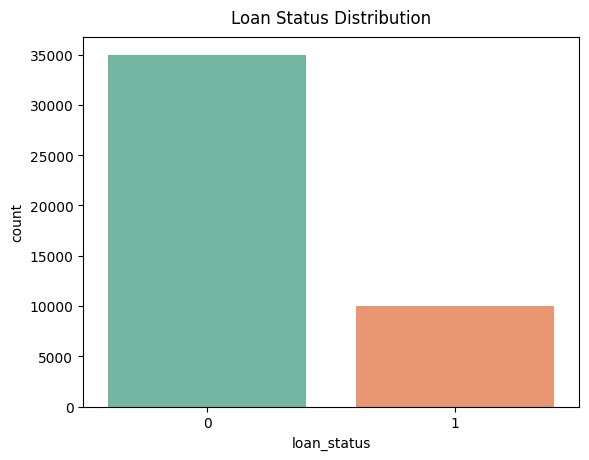

In [11]:
sns.countplot(x='loan_status', data=df, palette='Set2')
plt.title('Loan Status Distribution', pad=10)
plt.show();

It is clearly evident from the above plot that the target binary classes are significantly imbalanced. This may adversely affect the performance of machine learning models.

In [12]:
df.education.value_counts()

,count
education,
Bachelor,13399
Associate,12028
High School,11972
Master,6980
Doctorate,621


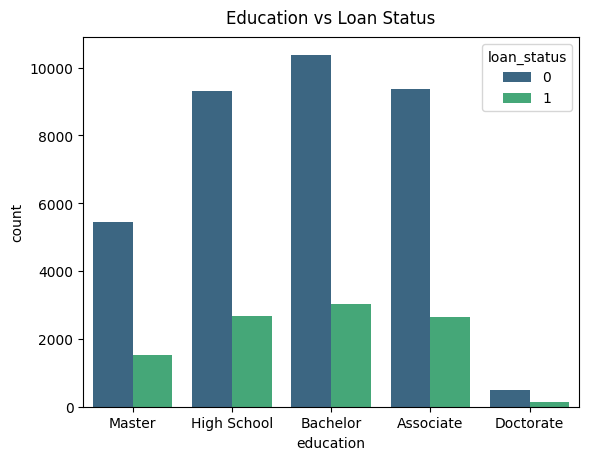

In [13]:
sns.countplot(x='education', data=df, hue='loan_status', palette='viridis')
plt.title('Education vs Loan Status', pad=10)
plt.show();

## Data Preprocessing

In [14]:
# Ordinal Encoding
education_encoder = OrdinalEncoder(categories=[['High School','Associate','Bachelor','Master','Doctorate']], dtype=int)
df.education = education_encoder.fit_transform(df[['education']])
df.education.value_counts()

,count
education,
2,13399
1,12028
0,11972
3,6980
4,621


In [15]:
cat_cols = ['gender','home_ownership','loan_intent','previous_loan_defaults_on_file']

# One-hot encoding
def one_hot_encode(data,column):
  encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
  encoded_data = encoder.fit_transform(data[[column]])
  encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())
  data = pd.concat([data,encoded_df],axis=1)
  data.drop(column, axis=1, inplace=True)
  return data

In [16]:
for col in cat_cols:
  df = one_hot_encode(df,col)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 45000 non-null  float64
 1   education                           45000 non-null  int64  
 2   income                              45000 non-null  float64
 3   employment_experience               45000 non-null  int64  
 4   loan_amount                         45000 non-null  float64
 5   loan_interest_rate                  45000 non-null  float64
 6   loan_percent_income                 45000 non-null  float64
 7   cb_person_cred_hist_length          45000 non-null  float64
 8   credit_score                        45000 non-null  int64  
 9   loan_status                         45000 non-null  int64  
 10  gender_male                         45000 non-null  float64
 11  home_ownership_OTHER                45000

## Feature Splitting (Train-Test Split)

In [18]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Selection

### Backward Elimination

In [20]:
def train_model(variables):
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train[list(variables)], y_train)
    return model

In [21]:
def score_model(model, variables):
    return AIC_score(y_train, model.predict_proba(X_train[variables])[:, 1], model)

In [22]:
allVariables = X_train.columns

# Backward elimination
back_model, back_variables = backward_elimination(allVariables, train_model, score_model, verbose=True)

# Summary on validation set
classificationSummary(y_test, back_model.predict(X_test[back_variables]))

Variables: age, education, income, employment_experience, loan_amount, loan_interest_rate, loan_percent_income, cb_person_cred_hist_length, credit_score, gender_male, home_ownership_OTHER, home_ownership_OWN, home_ownership_RENT, loan_intent_EDUCATION, loan_intent_HOMEIMPROVEMENT, loan_intent_MEDICAL, loan_intent_PERSONAL, loan_intent_VENTURE, previous_loan_defaults_on_file_Yes
Start: score=26584.82
Step: score=13816.57, remove income
Step: score=8628.74, remove loan_amount
Step: score=8626.35, remove age
Step: score=8623.71, remove loan_intent_HOMEIMPROVEMENT
Step: score=8623.71, remove None
Confusion Matrix (Accuracy 0.8873)

       Prediction
Actual    0    1
     0 6542  448
     1  566 1444


### Forward Selection

In [23]:
def train_model_forward(variables):
    if len(variables) == 0:
        return None
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train[list(variables)], y_train)
    return model

In [24]:
def score_model_forward(model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    return AIC_score(y_train, model.predict_proba(X_train[variables])[:, 1], model)

In [25]:
# Forward selection
fwd_model, fwd_variables = forward_selection(X_train.columns, train_model_forward, score_model_forward, verbose=True)

# Summary on validation set
classificationSummary(y_test, fwd_model.predict(X_test[fwd_variables]))

Variables: age, education, income, employment_experience, loan_amount, loan_interest_rate, loan_percent_income, cb_person_cred_hist_length, credit_score, gender_male, home_ownership_OTHER, home_ownership_OWN, home_ownership_RENT, loan_intent_EDUCATION, loan_intent_HOMEIMPROVEMENT, loan_intent_MEDICAL, loan_intent_PERSONAL, loan_intent_VENTURE, previous_loan_defaults_on_file_Yes
Start: score=38941.30, constant
Step: score=26441.48, add previous_loan_defaults_on_file_Yes
Step: score=19150.26, add loan_percent_income
Step: score=13251.13, add loan_interest_rate
Step: score=11242.09, add home_ownership_RENT
Step: score=10083.63, add credit_score
Step: score=9637.10, add loan_intent_VENTURE
Step: score=9235.83, add loan_intent_EDUCATION
Step: score=8955.70, add loan_intent_PERSONAL
Step: score=8710.95, add home_ownership_OWN
Step: score=8666.07, add employment_experience
Step: score=8638.88, add loan_intent_MEDICAL
Step: score=8628.75, add home_ownership_OTHER
Step: score=8622.39, add age
S

In [26]:
print("Variables selected by Backward Elimination:")
print(back_variables)

print("\nVariables selected by Forward Selection:")
print(fwd_variables)

Variables selected by Backward Elimination:
['education', 'employment_experience', 'loan_interest_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'gender_male', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'previous_loan_defaults_on_file_Yes']

Variables selected by Forward Selection:
['previous_loan_defaults_on_file_Yes', 'loan_percent_income', 'loan_interest_rate', 'home_ownership_RENT', 'credit_score', 'loan_intent_VENTURE', 'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'home_ownership_OWN', 'employment_experience', 'loan_intent_MEDICAL', 'home_ownership_OTHER', 'age']


In [27]:
selected_variables = list(set(back_variables).intersection(set(fwd_variables)))
print("Selected Variables:")
print(selected_variables)

Selected Variables:
['loan_intent_PERSONAL', 'loan_percent_income', 'credit_score', 'loan_intent_VENTURE', 'loan_intent_EDUCATION', 'employment_experience', 'home_ownership_OWN', 'loan_intent_MEDICAL', 'home_ownership_OTHER', 'previous_loan_defaults_on_file_Yes', 'home_ownership_RENT', 'loan_interest_rate']


In [28]:
len(selected_variables), X_train.shape[1]

(12, 19)

We reduced the number of predictor variables significantly from 19 to 12.

In [29]:
final_X_train = X_train[selected_variables]
final_X_test = X_test[selected_variables]

In [30]:
# Feature Scaling
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(final_X_train)
scaled_X_test = scaler.transform(final_X_test)

## Model Training & Evaluation

### Logistic Regression

In [31]:
# Logistic Regression
logit_reg = LogisticRegression(penalty='l2',C=1e42, solver='liblinear')
logit_reg.fit(scaled_X_train, y_train)

LogisticRegression(C=1e+42, solver='liblinear')

In [32]:
# Predictions
logit_pred_train = logit_reg.predict(scaled_X_train)
logit_pred_test = logit_reg.predict(scaled_X_test)

In [33]:
lr_probs = logit_reg.predict_proba(scaled_X_test)[:, 1]

In [34]:
lr_results_df = pd.DataFrame({
    'actual': y_test,
    'p(1)': lr_probs
}).sort_values(by='p(1)', ascending=False)
lr_results_df.head()

,actual,p(1)
596,1,0.999176
43457,1,0.997378
4,1,0.997277
42975,1,0.997039
29278,1,0.997033


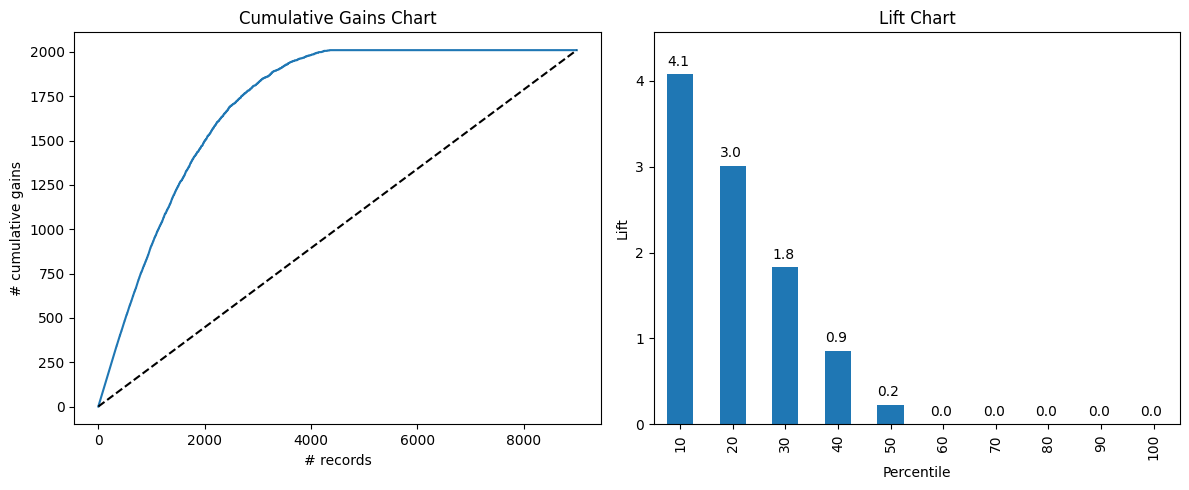

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
gainsChart(lr_results_df['actual'], ax=axes[0])
liftChart(lr_results_df['p(1)'], title=False, ax=axes[1])
axes[0].set_title("Cumulative Gains Chart")
axes[1].set_title("Lift Chart")
plt.tight_layout()
plt.show()

In [36]:
# Evaluation
print("Logistic Regression - Training Set")
classificationSummary(y_train, logit_pred_train)

print("\nLogistic Regression - Test Set")
classificationSummary(y_test, logit_pred_test)

Logistic Regression - Training Set
Confusion Matrix (Accuracy 0.8922)

       Prediction
Actual     0     1
     0 26230  1780
     1  2101  5889

Logistic Regression - Test Set
Confusion Matrix (Accuracy 0.8874)

       Prediction
Actual    0    1
     0 6543  447
     1  566 1444


In [37]:
print("AIC:", AIC_score(y_test, logit_pred_test, df=scaled_X_train.shape[1]+1))
print("BIC:", BIC_score(y_test, logit_pred_test, df=scaled_X_train.shape[1]+1))

AIC: 5910.118429057053
BIC: 6009.58814704551


### CART

In [38]:
# CART model
cart_model = DecisionTreeClassifier(max_depth=6,random_state=42)
cart_model.fit(final_X_train, y_train) # no scaling needed for trees

DecisionTreeClassifier(max_depth=6, random_state=42)

In [39]:
# Predictions
cart_pred_train = cart_model.predict(final_X_train)
cart_pred_test = cart_model.predict(final_X_test)

In [40]:
cart_probs = cart_model.predict_proba(final_X_test)[:, 1]

cart_results_df = pd.DataFrame({
    'actual': y_test,
    'p(1)': cart_probs
}).sort_values(by='p(1)', ascending=False)
cart_results_df.head()

,actual,p(1)
43592,1,1.0
8473,1,1.0
14337,1,1.0
25118,1,1.0
44371,1,1.0


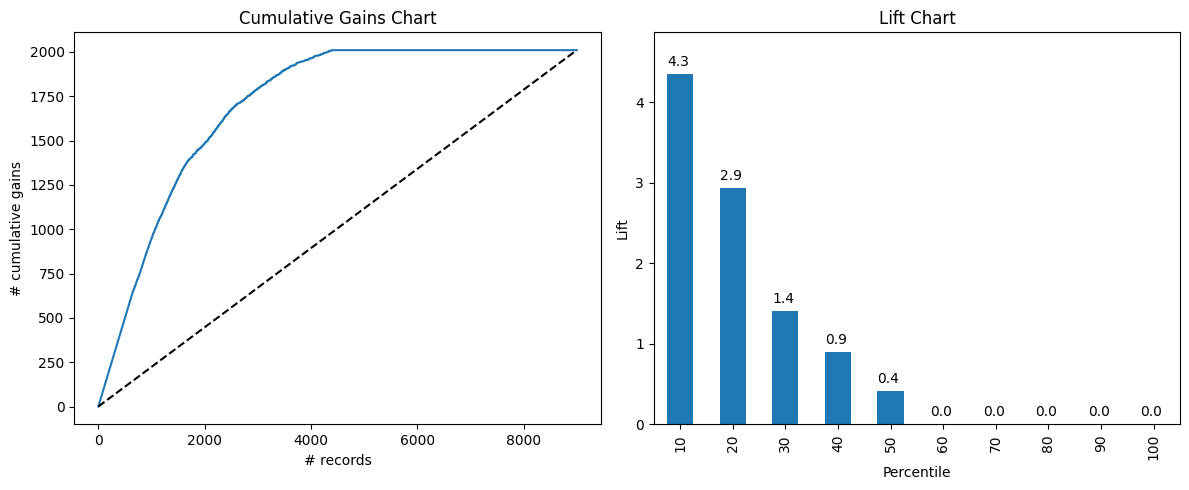

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
gainsChart(cart_results_df['actual'], ax=axes[0])
liftChart(cart_results_df['p(1)'], title=False, ax=axes[1])
axes[0].set_title("Cumulative Gains Chart")
axes[1].set_title("Lift Chart")
plt.tight_layout()
plt.show()

In [42]:
# Evaluation
print("CART - Training Set")
classificationSummary(y_train, cart_pred_train)

print("\nCART - Test Set")
classificationSummary(y_test, cart_pred_test)

CART - Training Set
Confusion Matrix (Accuracy 0.9046)

       Prediction
Actual     0     1
     0 26993  1017
     1  2418  5572

CART - Test Set
Confusion Matrix (Accuracy 0.8972)

       Prediction
Actual    0    1
     0 6690  300
     1  625 1385


In [43]:
print("AIC:", AIC_score(y_test, cart_pred_test, df=scaled_X_train.shape[1]+1))
print("BIC:", BIC_score(y_test, cart_pred_test, df=scaled_X_train.shape[1]+1))

AIC: 5092.218528430727
BIC: 5191.688246419184


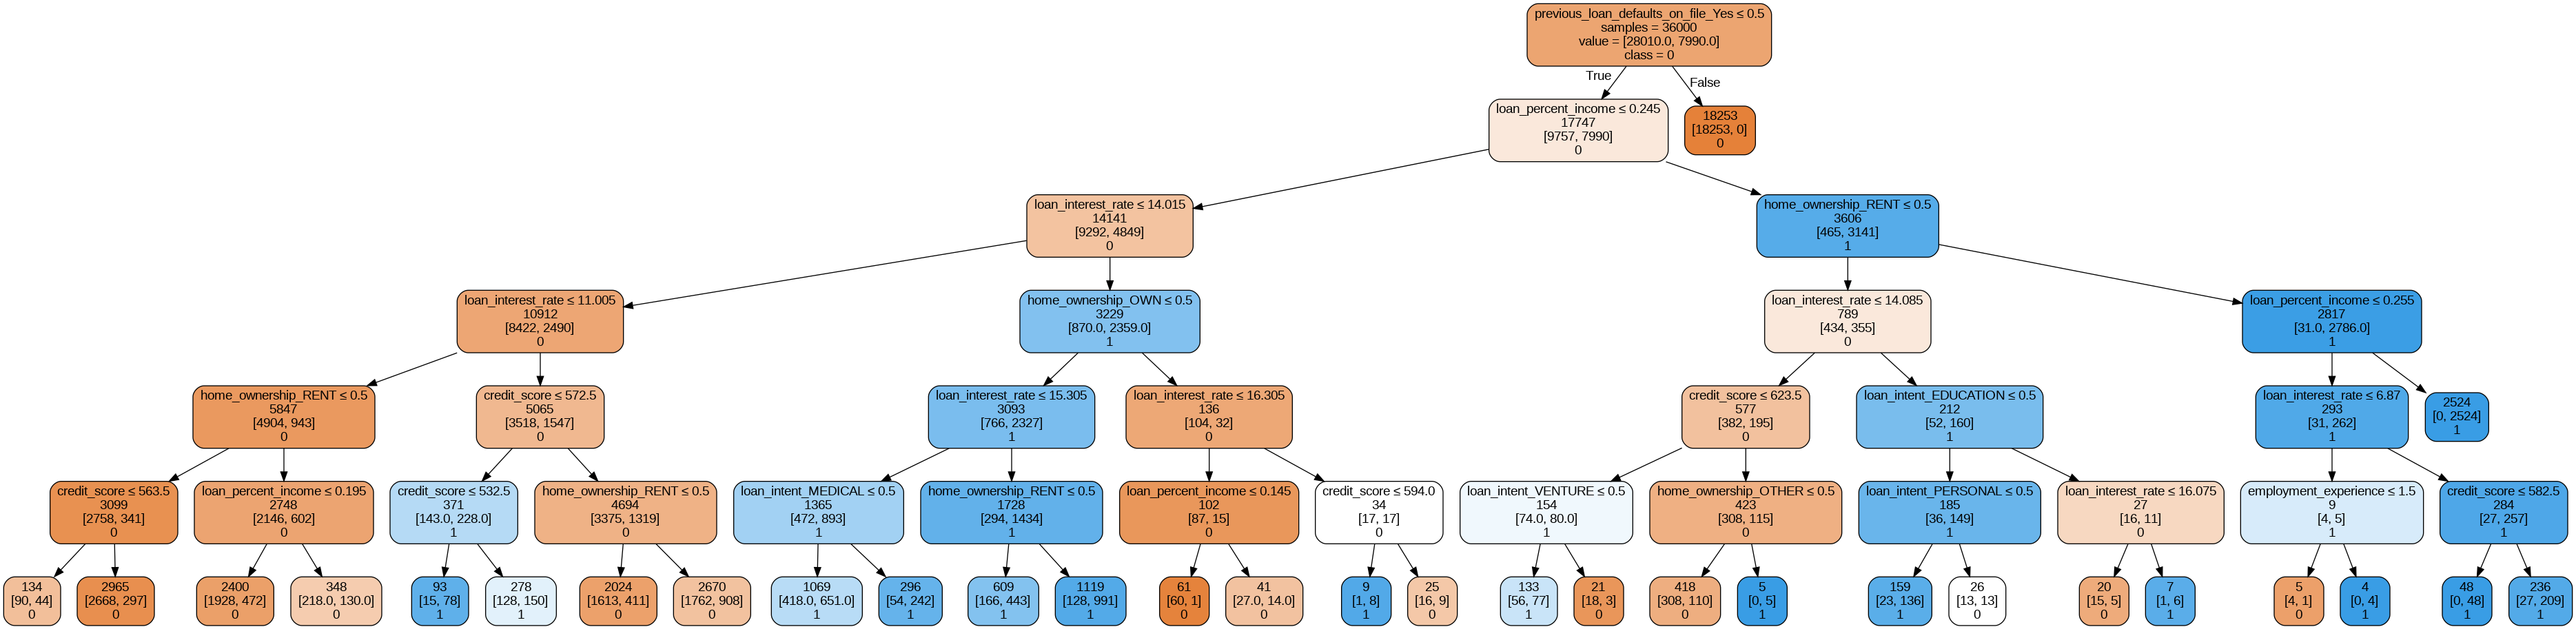

In [44]:
# Visualize the Decision Tree
plotDecisionTree(cart_model, feature_names=final_X_train.columns.tolist(), class_names=['0', '1'])

### Naive Bayes

In [45]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(scaled_X_train, y_train)

GaussianNB()

In [46]:
# Predictions
nb_pred_train = nb_model.predict(scaled_X_train)
nb_pred_test = nb_model.predict(scaled_X_test)

In [47]:
nb_probs = nb_model.predict_proba(scaled_X_test)[:, 1]

nb_results_df = pd.DataFrame({
    'actual': y_test,
    'p(1)': nb_probs
}).sort_values(by='p(1)', ascending=False)
nb_results_df.head()

,actual,p(1)
15983,0,1.0
31443,1,1.0
2351,0,1.0
6282,1,1.0
1503,1,1.0


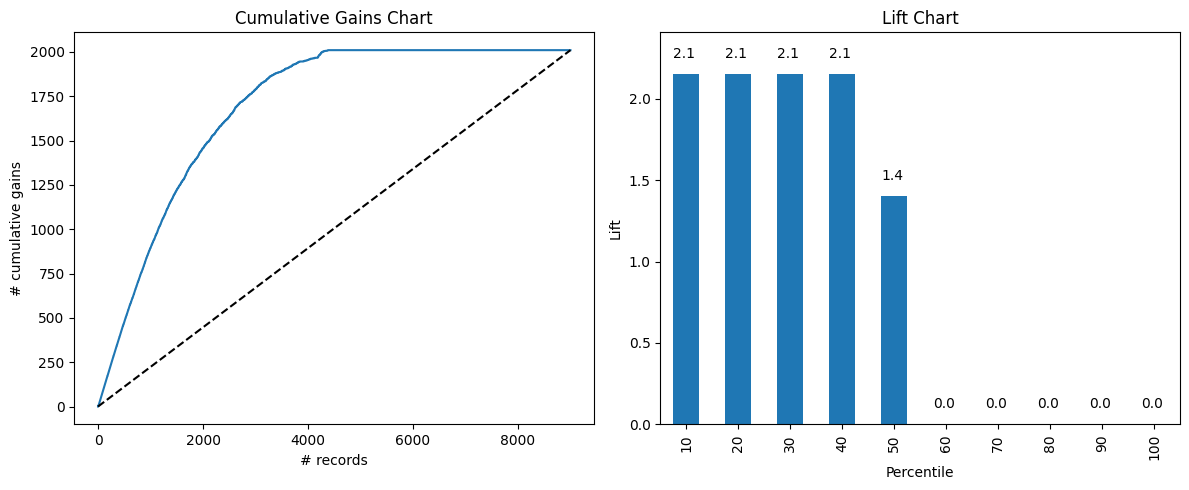

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
gainsChart(nb_results_df['actual'], ax=axes[0])
liftChart(nb_results_df['p(1)'], title=False, ax=axes[1])
axes[0].set_title("Cumulative Gains Chart")
axes[1].set_title("Lift Chart")
plt.tight_layout()
plt.show()

In [49]:
# Evaluation
print("Naive Bayes - Training Set")
classificationSummary(y_train, nb_pred_train)

print("\nNaive Bayes - Test Set")
classificationSummary(y_test, nb_pred_test)

Naive Bayes - Training Set
Confusion Matrix (Accuracy 0.7456)

       Prediction
Actual     0     1
     0 19018  8992
     1   166  7824

Naive Bayes - Test Set
Confusion Matrix (Accuracy 0.7489)

       Prediction
Actual    0    1
     0 4772 2218
     1   42 1968


In [50]:
print("AIC:", AIC_score(y_test, nb_pred_test, df=scaled_X_train.shape[1]+1))
print("BIC:", BIC_score(y_test, nb_pred_test, df=scaled_X_train.shape[1]+1))

AIC: 13132.155721215886
BIC: 13231.625439204343


### K Nearest Neighbors (KNN)

In [51]:
k_scores = []

# Loop to find the best k
for k in range(1,21):
  knn_model = KNeighborsClassifier(n_neighbors=k)
  knn_model.fit(scaled_X_train, y_train)
  acc = accuracy_score(y_test, knn_model.predict(scaled_X_test))
  k_scores.append((k,acc))

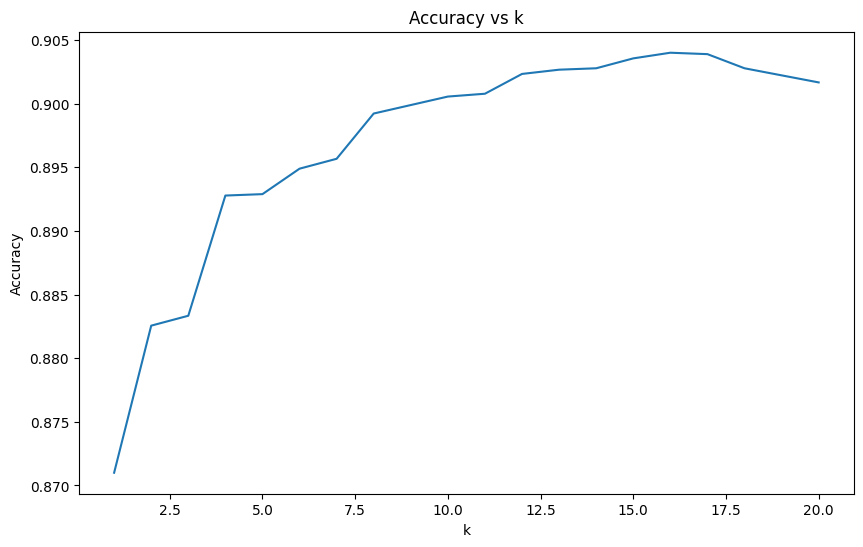

In [52]:
plt.figure(figsize=(10,6))
plt.plot([k for k,acc in k_scores], [acc for k,acc in k_scores])
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show();

In [53]:
# Choose best k
best_k = max(k_scores, key=lambda x: x[1])[0]
print("Best k:", best_k)

Best k: 16


In [54]:
# Final KNN model
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(scaled_X_train, y_train)

KNeighborsClassifier(n_neighbors=16)

In [55]:
# Predictions
knn_pred_train = knn_model.predict(scaled_X_train)
knn_pred_test = knn_model.predict(scaled_X_test)

In [56]:
knn_probs = knn_model.predict_proba(scaled_X_test)[:, 1]

knn_results_df = pd.DataFrame({
    'actual': y_test,
    'p(1)': knn_probs
}).sort_values(by='p(1)', ascending=False)
knn_results_df.head()

,actual,p(1)
431,1,1.0
2265,1,1.0
43592,1,1.0
44347,1,1.0
14337,1,1.0


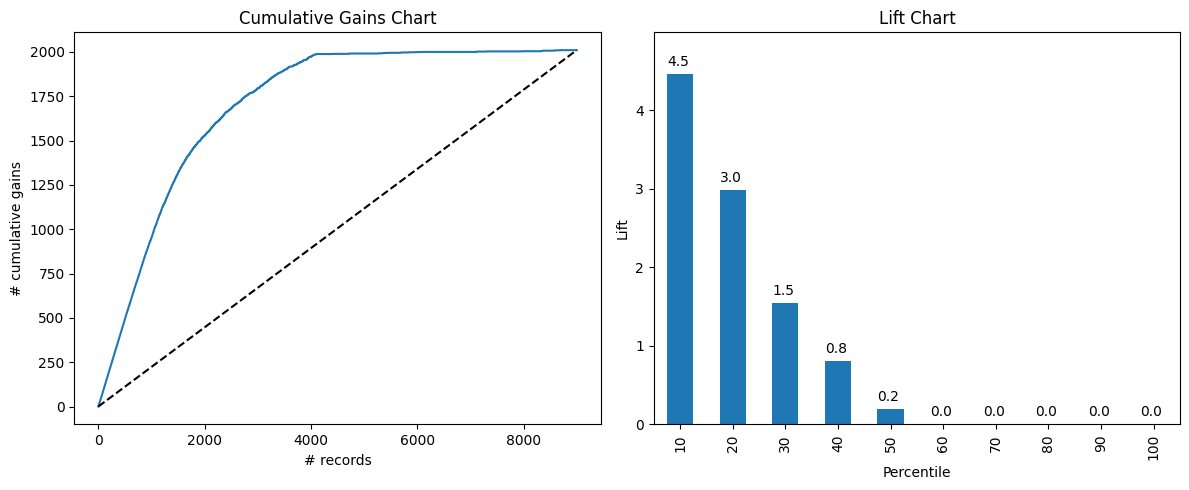

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
gainsChart(knn_results_df['actual'], ax=axes[0])
liftChart(knn_results_df['p(1)'], title=False, ax=axes[1])
axes[0].set_title("Cumulative Gains Chart")
axes[1].set_title("Lift Chart")
plt.tight_layout()
plt.show()

In [58]:
# Evaluation
print("KNN - Training Set")
classificationSummary(y_train, knn_pred_train)

print("\nKNN - Test Set")
classificationSummary(y_test, knn_pred_test)

KNN - Training Set
Confusion Matrix (Accuracy 0.9117)

       Prediction
Actual     0     1
     0 27167   843
     1  2336  5654

KNN - Test Set
Confusion Matrix (Accuracy 0.9040)

       Prediction
Actual    0    1
     0 6769  221
     1  643 1367


In [59]:
print("AIC:", AIC_score(y_test, knn_pred_test, df=scaled_X_train.shape[1]+1))
print("BIC:", BIC_score(y_test, knn_pred_test, df=scaled_X_train.shape[1]+1))

AIC: 4478.2298100554035
BIC: 4577.6995280438605


## Model Performance Comparison

In [60]:
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC-AUC Score': roc_auc_score(y_true, y_pred)
    }

In [61]:
model_scores = [
    evaluate_model("Logistic Regression", y_test, logit_pred_test),
    evaluate_model("CART", y_test, cart_pred_test),
    evaluate_model("Naive Bayes", y_test, nb_pred_test),
    evaluate_model(f"KNN (k={best_k})", y_test, knn_pred_test)
]

In [62]:
model_comparison_df = pd.DataFrame(model_scores)
display(model_comparison_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True))

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC Score
0,KNN (k=16),0.904000,0.860831,0.680100,0.759867,0.824241
1,CART,0.897222,0.821958,0.689055,0.749662,0.823068
2,Logistic Regression,0.887444,0.763617,0.718408,0.740323,0.827230
3,Naive Bayes,0.748889,0.470139,0.979104,0.635249,0.830897


We can clearly notice that the K Nearest Neighbors model with k=16 is the best performing classifier with an accuracy of more than 90% on the test set.

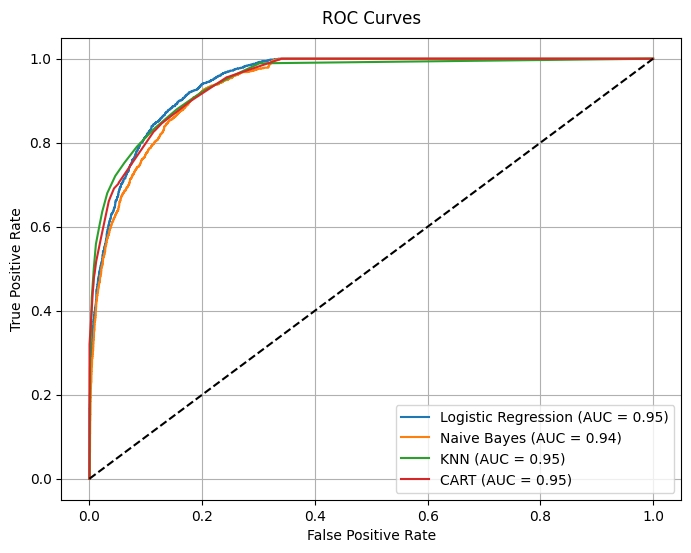

In [63]:
plt.figure(figsize=(8, 6))

# Logistic Regression
lr_probs = logit_reg.predict_proba(scaled_X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, lr_probs):.2f})')

# Naive Bayes
nb_probs = nb_model.predict_proba(scaled_X_test)[:, 1]
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {roc_auc_score(y_test, nb_probs):.2f})')

# KNN
knn_probs = knn_model.predict_proba(scaled_X_test)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
plt.plot(knn_fpr, knn_tpr, label=f'KNN (AUC = {roc_auc_score(y_test, knn_probs):.2f})')

# CART
cart_probs = cart_model.predict_proba(final_X_test)[:, 1]
cart_fpr, cart_tpr, _ = roc_curve(y_test, cart_probs)
plt.plot(cart_fpr, cart_tpr, label=f'CART (AUC = {roc_auc_score(y_test, cart_probs):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', pad=10)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()